In [ ]:
import pandas as pd
import numpy as np

from pyAudioAnalysis import audioBasicIO 
from pyAudioAnalysis import ShortTermFeatures 

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import librosa.feature
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import json

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
count_emotions_wavs = {"angry": 0, "sad": 0, "neutral": 0, "positive": 0, "other": 0}
crowd_train_path = "DATASET_PATH/processed_dataset_090/aggregated_dataset/crowd_train.jsonl"
path_wav_file_train = "DATASET_PATH/crowd_train/wavs/"
wavs = []
arr_path = []
arr_emotions = []

with open(crowd_train_path) as file:
    wavs = [f for f in file]

k = 0
for wav in wavs:
    if k % 2 == 0:
        if count_emotions_wavs[json.loads(wav)['emotion']] < 1500:
            emotion = json.loads(wav)['emotion']
            arr_path.append(path_wav_file_train + json.loads(wav)['hash_id'] + ".wav")
            arr_emotions.append(emotion)
            count_emotions_wavs[json.loads(wav)['emotion']] += 1
    k += 1
print()


In [4]:
count_emotions_wavs

{'angry': 1500, 'sad': 1500, 'neutral': 1500, 'positive': 1500, 'other': 1483}

# Создадим DataFrame с эмоцией и ссылкой на аудиофайл

In [5]:
emotion_df = pd.DataFrame(arr_emotions, columns=['Emotion'])
path_df = pd.DataFrame(arr_path, columns=['Path'])
Crowd_df = pd.concat([emotion_df, path_df], axis=1)
Crowd_df

,Emotion,Path
0,angry,DATASET_PATH/crowd_train/wavs/475e76f77ac1ed7c...
1,neutral,DATASET_PATH/crowd_train/wavs/2f9438ef68395c70...
2,neutral,DATASET_PATH/crowd_train/wavs/9937036a9c0dba20...
3,neutral,DATASET_PATH/crowd_train/wavs/fb0ae78586a23501...
4,neutral,DATASET_PATH/crowd_train/wavs/196dcf9e1aaac46c...
...,...,...
7478,other,DATASET_PATH/crowd_train/wavs/9545d4a66c220154...
7479,other,DATASET_PATH/crowd_train/wavs/df295979df17dd61...
7480,other,DATASET_PATH/crowd_train/wavs/7b6ecca64e5f0551...
7481,other,DATASET_PATH/crowd_train/wavs/6662d94bdc03036c...


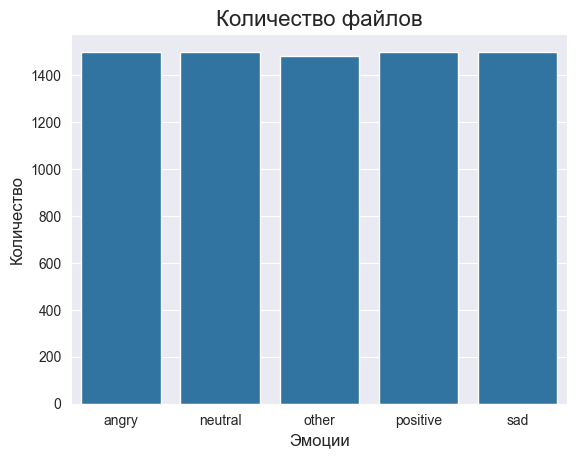

In [6]:
plt.title('Количество файлов', size=16)
sns.countplot(x=Crowd_df.Emotion)
plt.ylabel('Количество', size=12)
plt.xlabel('Эмоции', size=12)
plt.show()

In [44]:
path = np.array(Crowd_df.Path)[0]
path

'DATASET_PATH/crowd_train/wavs/475e76f77ac1ed7cabafca740b15b32a.wav'

In [45]:
data, sample_rate = librosa.load(path)
pd.DataFrame(data, columns=['Number']).max()

Number    0.767343
dtype: float32

In [46]:
Audio(path)

In [ ]:
# Добавляю шум в данные
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Если rate > 1, то увеличиваю продолжительность аудиосигнала, иначе - уменьшаю
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Сдвиг данных (в данные аудиосигнала добавляются новые рандомные данные)
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# 
def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=0.7)

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Crowd_df.Path, Crowd_df.Emotion):
    feature = get_features(path)
    # print("feature: ", feature)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
# print("X: ", X)
# print("Y: ", Y)


In [14]:
len(X), len(Y), Crowd_df.Path.shape

(19194, 19194, (7483,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.072156,0.489364,0.524334,0.445583,0.349968,0.327535,0.351265,0.363754,0.452142,0.445644,...,1.379467e-10,1.080815e-10,8.772962e-11,7.321864e-11,6.275209e-11,5.514984e-11,4.992661e-11,4.628495e-11,4.410689e-11,angry
1,0.141632,0.565910,0.601655,0.536756,0.454812,0.434946,0.392188,0.398637,0.495155,0.513153,...,1.723667e-02,1.788930e-02,1.746639e-02,1.764207e-02,1.675447e-02,1.598007e-02,1.670894e-02,1.778073e-02,1.820268e-02,angry
2,0.085161,0.519448,0.498895,0.562369,0.499082,0.408731,0.368873,0.385064,0.412256,0.503286,...,8.617729e-11,7.111940e-11,6.814678e-11,6.948039e-11,5.562183e-11,5.253229e-11,5.577312e-11,4.022501e-11,1.436117e-11,angry
3,0.069634,0.596887,0.660452,0.695428,0.638292,0.623538,0.624481,0.660015,0.674550,0.695307,...,5.196929e-09,4.674353e-09,4.298421e-09,4.015684e-09,3.801982e-09,3.644098e-09,3.527749e-09,3.449707e-09,3.401923e-09,neutral
4,0.135281,0.706389,0.782142,0.777749,0.734202,0.729052,0.682214,0.680914,0.688565,0.689173,...,3.165819e-04,3.157912e-04,3.136849e-04,3.194820e-04,3.054788e-04,3.180045e-04,3.195020e-04,3.222640e-04,3.459231e-04,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19189,0.191189,0.786246,0.831564,0.843937,0.847369,0.859014,0.858831,0.871438,0.871768,0.885507,...,7.913783e-07,8.391741e-07,7.802166e-07,7.875597e-07,7.675838e-07,7.742777e-07,7.835148e-07,8.213993e-07,7.764973e-07,other
19190,0.180194,0.756923,0.794380,0.810973,0.793465,0.802532,0.825235,0.847413,0.873452,0.873270,...,1.727566e-10,1.226910e-10,1.056454e-10,8.710433e-11,7.516384e-11,6.921894e-11,6.942043e-11,4.318593e-11,1.186418e-11,other
19191,0.038181,0.743785,0.756853,0.775376,0.809547,0.817861,0.841172,0.869987,0.890308,0.930191,...,2.035463e-09,1.879160e-09,1.767638e-09,1.684284e-09,1.621988e-09,1.576960e-09,1.544187e-09,1.522828e-09,1.509624e-09,other
19192,0.038443,0.744653,0.757891,0.776413,0.810386,0.818718,0.841285,0.869737,0.890194,0.930142,...,2.297629e-09,2.149106e-09,2.044069e-09,1.910265e-09,1.871396e-09,1.846682e-09,1.813844e-09,1.789874e-09,1.759318e-09,other


In [16]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# Кодируем наши данные

In [17]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Разделяем данные

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14395, 162), (14395, 5), (4799, 162), (4799, 5))

# Масштабируем наших данных с помощью sklearn

In [19]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14395, 162), (14395, 5), (4799, 162), (4799, 5))

# Делаем совместимыми наши данные с моделью

In [20]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14395, 162, 1), (14395, 5), (4799, 162, 1), (4799, 5))

# Модель

In [21]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,189 (2.13 MB)

 Trainable params: 557,189 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 187ms/step - accuracy: 0.2633 - loss: 1.5352 - val_accuracy: 0.3467 - val_loss: 1.4201 - learning_rate: 0.0010
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.3190 - loss: 1.4345 - val_accuracy: 0.3709 - val_loss: 1.3893 - learning_rate: 0.0010
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.3487 - loss: 1.3947 - val_accuracy: 0.3605 - val_loss: 1.3858 - learning_rate: 0.0010
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.3609 - loss: 1.3907 - val_accuracy: 0.3774 - val_loss: 1.3576 - learning_rate: 0.0010
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.3709 - loss: 1.3672 - val_accuracy: 0.3834 - val_loss: 1.3377 - learning_rate: 0.0010
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.3823 - loss: 1.3513 - val_accuracy: 0.4040 - val_loss: 1.3268 - learning_rate: 0.0010
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.3

In [27]:
model.save("models/Emotions1500.keras")

In [47]:
from keras.models import load_model
model = load_model("models/Emotions1500.keras")

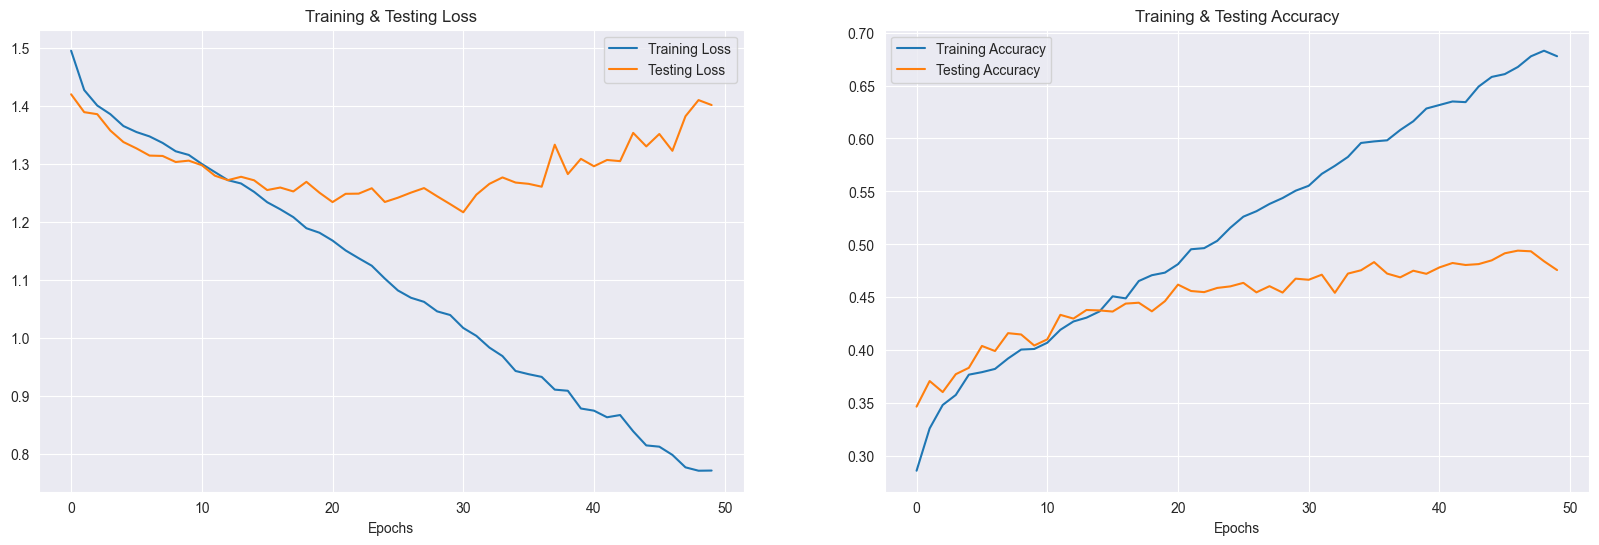

In [50]:
# print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [64]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)
# df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
# df['Predicted Labels'] = y_pred.flatten()
# df['Actual Labels'] = y_test.flatten()
# 
# df.head(10)

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
